In [100]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
from PIL import Image
from pathlib import Path

# Torch dependencies
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
print(torch.cuda.is_available())

True


In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("arunrk7/surface-crack-detection")

# print("Path to dataset files:", path)

In [3]:
# # Moving the datasets
# src_dir = 'C:/Users/super/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1'
# dest_dir = 'crack_dataset_kaggle'
# files = os.listdir(src_dir)

# shutil.copytree(src_dir, dest_dir)

In [4]:
# # Make directories for dataset and generated data
# # os.makedirs('dataset', exist_ok=True)
# os.makedirs('generated_images', exist_ok=True)

In [3]:
# Defining data path
dest_dir = 'crack_dataset_kaggle'
data_path = Path(dest_dir)

In [4]:
# Function to show generated image
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0, 1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

In [5]:
np.random.seed(42)
# Visualize only from positive folder
image_path_list = list(data_path.glob("*/*.jpg"))
random_image = random.choice(image_path_list)
img = Image.open(random_image)
print(random_image)

crack_dataset_kaggle\Train\09693.jpg


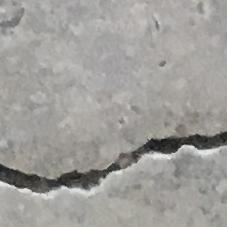

In [6]:
img

In [7]:
img.size

(227, 227)

In [257]:
# Transforming data
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # transforms.RandomHorizontalFlip(p=0.2),
    # transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5]),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [258]:
# def plot_transformed_images(image_path, transform, n=3):
#     random_image_path = random.sample(image_path, k=n)
#     for image_path in random_image_path:
#         with Image.open(image_path) as f:
#             fig, ax = plt.subplots(nrows=1, ncols=2)
#             ax[0].imshow(f)
#             ax[0].set_title("Original Image")

#             # Transformed image
#             transformed_image = transform(f).permute(1, 2, 0)
#             ax[1].imshow(transformed_image)
#             ax[1].set_title("Transformed Image")

## Model and hyperparameters

In [273]:
# Hyperparameters
class Config:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lr = 2e-4
    image_size = 277
    batch_size = 64
    channels_img = 3
    z_dim = 100
    num_epochs = 20
    log_step = 625

In [260]:
# Loading image data
dataset = datasets.ImageFolder(root=data_path,
                               transform=data_transform)

dataloader = DataLoader(dataset=dataset,
                        batch_size=Config.batch_size,
                        shuffle=True)

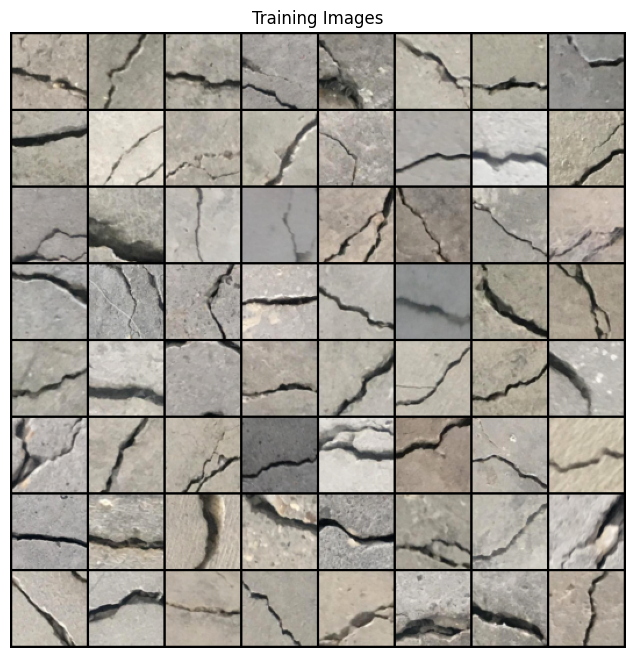

In [261]:
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(Config.device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()

## DCGAN

In [262]:
# Define discriminator
def dc_disc_block(in_dim, out_dim, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(0.2, inplace=True),
    )

class DCDiscriminator(nn.Module):
    def __init__(self, channels_img=3, conv_dim=64):
        super(DCDiscriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            dc_disc_block(conv_dim, conv_dim*2, kernel_size=4, stride=2, padding=1),
            dc_disc_block(conv_dim*2, conv_dim*4, kernel_size=4, stride=2, padding=1),
            dc_disc_block(conv_dim*4, conv_dim*8, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(conv_dim*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)
        # x = self.disc(x)
        # return x.view(len(x), -1)

In [263]:
# Define generator
def dc_gen_block(in_dim, out_dim, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
    )

class DCGenerator(nn.Module):
    def __init__(self, z_dim, channels_img=3, conv_dim=64):
        super(DCGenerator, self).__init__()
        # self.in_dim = in_dim
        self.gen = nn.Sequential(
            dc_gen_block(z_dim, conv_dim*8, kernel_size=4, stride=1, padding=0),
            dc_gen_block(conv_dim*8, conv_dim*4, kernel_size=4, stride=2, padding=1),
            dc_gen_block(conv_dim*4, conv_dim*2, kernel_size=4, stride=2, padding=1),
            dc_gen_block(conv_dim*2, conv_dim, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(conv_dim, channels_img, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        # x = x.view(len(x), self.in_dim, 1, 1) # reshape: (bs, in_size, 1, 1)
        return self.gen(x)

## Model, optimizer, and loss

In [264]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [265]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = DCDiscriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)
    gen = DCGenerator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    print("Success")

In [266]:
# Initialize models
gen = DCGenerator(z_dim=Config.z_dim).to(Config.device)
disc = DCDiscriminator().to(Config.device)

In [267]:
# Initialize weights
gen.apply(initialize_weights)
disc.apply(initialize_weights)

DCDiscriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kern

In [268]:
test()

Success


In [269]:
# Optimizer
gen_opt = optim.Adam(gen.parameters(), lr=Config.lr, betas=(0.5, 0.999))
disc_opt = optim.Adam(disc.parameters(), lr=Config.lr, betas=(0.5, 0.999))

In [270]:
# Loss
criterion = nn.BCELoss()

## Training loop

In [271]:
# writer_real = SummaryWriter(f"logs/real")
# writer_fake = SummaryWriter(f"logs/fake")

In [272]:
fixed_noise = torch.randn(Config.batch_size, Config.z_dim, 1, 1, device=Config.device)

In [274]:
fake_img_list = []
gen_losses = []
disc_losses = []
step = 0
gen_update_step = 2

for epoch in range(Config.num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        ### Initialize real and fake images
        real = real.to(Config.device)
        noise = torch.randn((real.size(0), Config.z_dim, 1, 1)).to(Config.device)
        fake = gen(noise)

        ### Train disrciminator
        disc_pred_real = disc(real).reshape(-1)
        # real_labels = torch.FloatTensor(disc_pred_real.size()).uniform_(0.7, 1.0).to(Config.device)
        real_labels = torch.ones_like(disc_pred_real).to(Config.device)
        disc_loss_real = criterion(disc_pred_real, real_labels)
        
        disc_pred_fake = disc(fake.detach()).reshape(-1)
        # fake_labels = torch.FloatTensor(disc_pred_fake.size()).uniform_(0.0, 0.3).to(Config.device)
        fake_labels = torch.zeros_like(disc_pred_fake).to(Config.device)
        disc_loss_fake = criterion(disc_pred_fake, fake_labels)

        # disc_loss = (disc_loss_real + disc_loss_fake) / 2
        disc_loss = disc_loss_real + disc_loss_fake
        
        disc.zero_grad()
        disc_loss.backward()
        disc_opt.step()

        ### Train generator
        for _ in range(gen_update_step):
            noise = torch.randn((Config.batch_size, Config.z_dim, 1, 1)).to(Config.device)
            fake = gen(noise)
            output = disc(fake).reshape(-1)
            gen_loss = criterion(output, torch.ones_like(output).to(Config.device))
            gen.zero_grad()
            gen_loss.backward()
            gen_opt.step()
    
        ### Save losses for plotting
        gen_losses.append(gen_loss.item())
        disc_losses.append(disc_loss.item())

        ### Print losses
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{Config.num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                    Loss Discriminator: {disc_loss:.4f},  Loss Generator: {gen_loss:.4f}")

            with torch.no_grad():
                # img_grid_real = vutils.make_grid(real[:32], normalize=True)
                # img_grid_fake = vutils.make_grid(fake[:32], normalize=True)

                # writer_real.add_image("Real", img_grid_real, global_step=step)
                # writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                fake = gen(fixed_noise).detach().cpu()

            fake_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            step += 1

Epoch [0/20] Batch 0/329                     Loss Discriminator: 1.7296,  Loss Generator: 0.3668
Epoch [0/20] Batch 100/329                     Loss Discriminator: 1.0287,  Loss Generator: 1.3815
Epoch [0/20] Batch 200/329                     Loss Discriminator: 1.8481,  Loss Generator: 0.2782
Epoch [0/20] Batch 300/329                     Loss Discriminator: 1.0153,  Loss Generator: 1.3074
Epoch [1/20] Batch 0/329                     Loss Discriminator: 1.1783,  Loss Generator: 1.9345
Epoch [1/20] Batch 100/329                     Loss Discriminator: 0.9821,  Loss Generator: 1.6062
Epoch [1/20] Batch 200/329                     Loss Discriminator: 0.8496,  Loss Generator: 1.9989
Epoch [1/20] Batch 300/329                     Loss Discriminator: 0.8253,  Loss Generator: 2.2919
Epoch [2/20] Batch 0/329                     Loss Discriminator: 1.0826,  Loss Generator: 0.9161
Epoch [2/20] Batch 100/329                     Loss Discriminator: 0.6354,  Loss Generator: 1.3023
Epoch [2/20] Bat

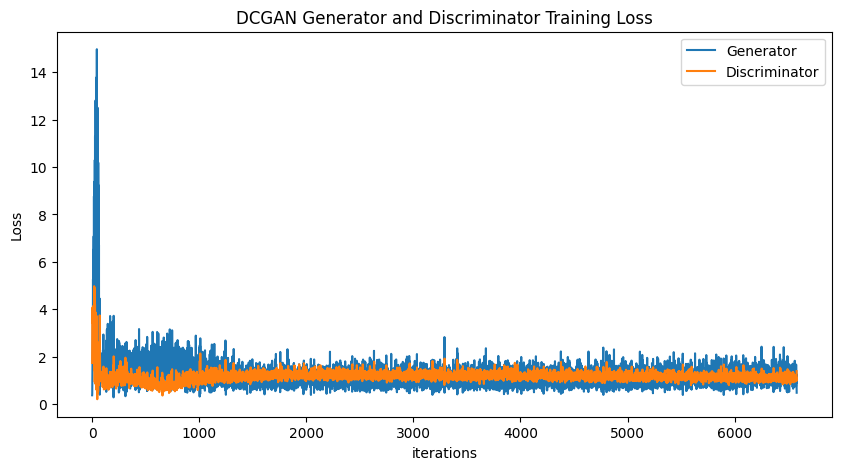

In [275]:
# Visualize training loss
plt.figure(figsize=(10, 5))
plt.title("DCGAN Generator and Discriminator Training Loss")
plt.plot(gen_losses, label="Generator")
plt.plot(disc_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

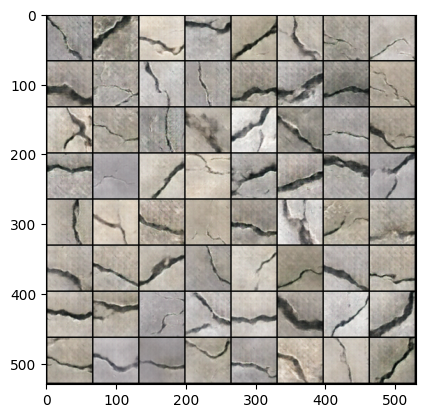

In [276]:
plt.imshow(np.transpose(fake_img_list[-1], (1,2,0)))

In [34]:
# fig = plt.figure(figsize=(8, 8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in fake_img_list]
# ani = animation.